In [1]:
import sys
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import segmentation_models_pytorch as smp

sys.path.append(r"../")

from utils.yaml_parser import YamlParser
from dataset import PascalVOCDataset


/Users/tim/anaconda3/envs/LearningML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hyperparameters = YamlParser("configs/hyperparameters.yaml")

In [3]:
dataset = PascalVOCDataset(root=r"../../data", image_set="val", download=False)
dataloader = DataLoader(dataset, batch_size=hyperparameters.batch_size, shuffle=False)
model = smp.Unet('resnet34', in_channels=3, classes=len(dataset.VOC_CLASSES)).to(hyperparameters.device)
model.load_state_dict(torch.load("weights/model.pt"))
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

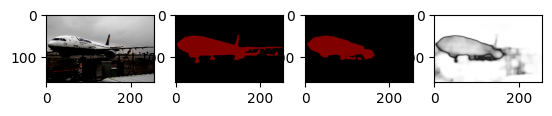

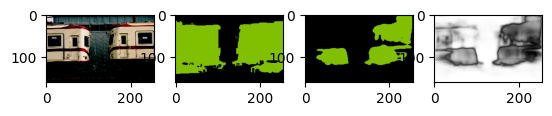

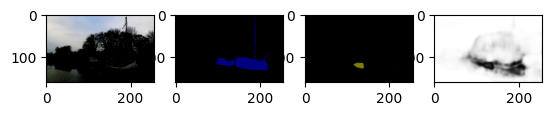

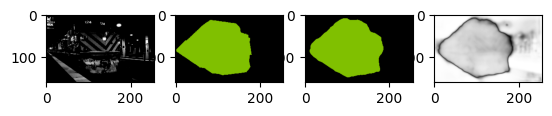

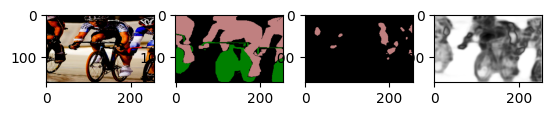

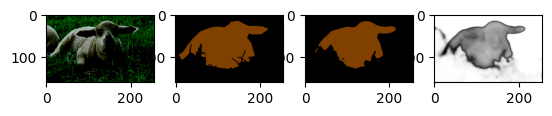

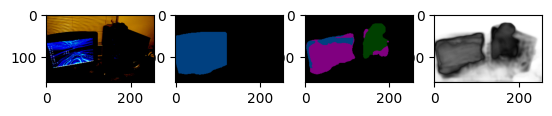

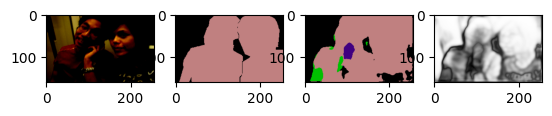

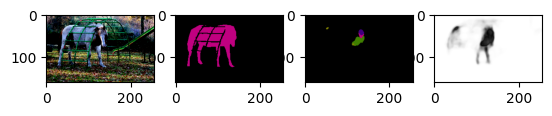

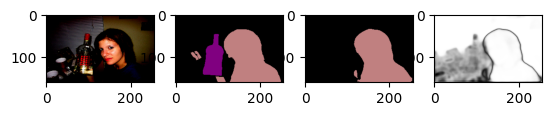

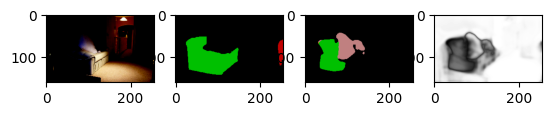

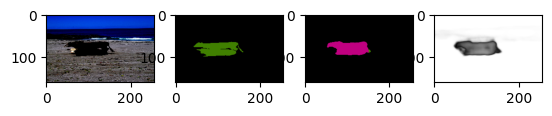

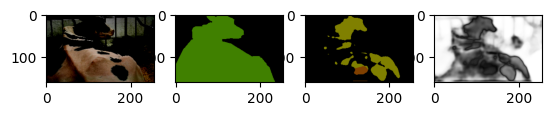

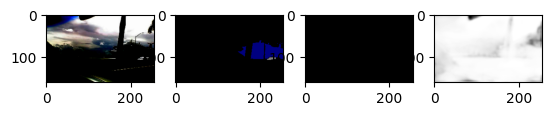

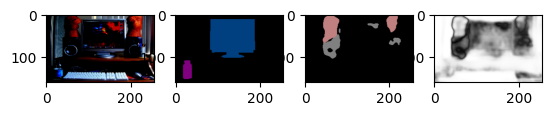

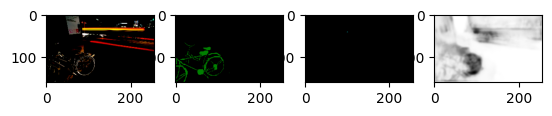

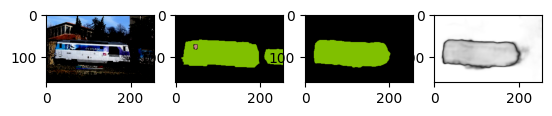

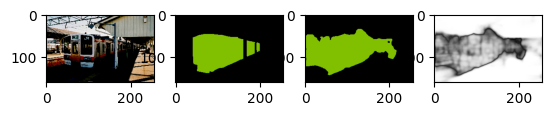

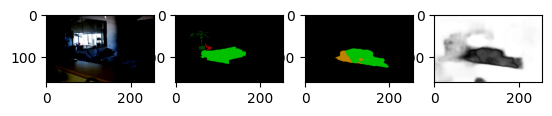

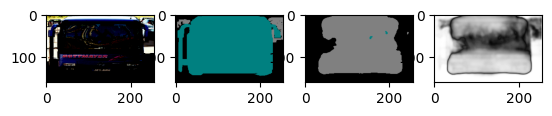

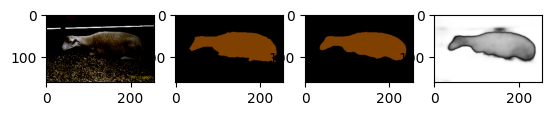

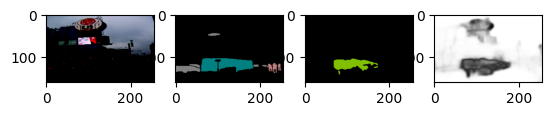

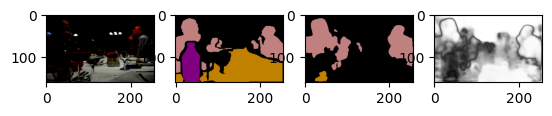

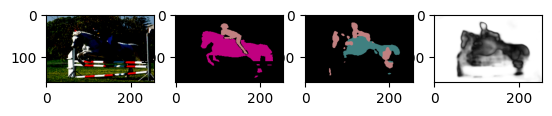

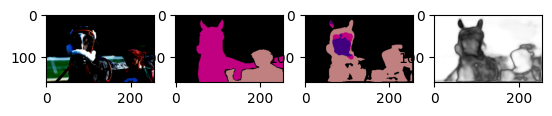

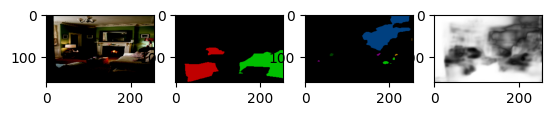

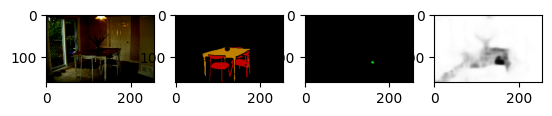

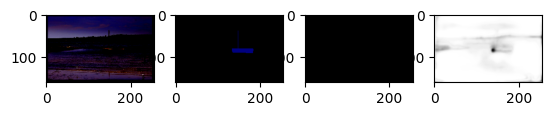

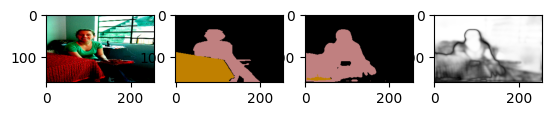

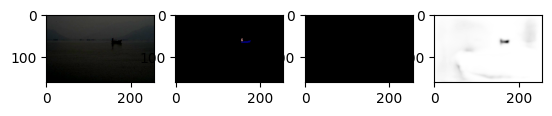

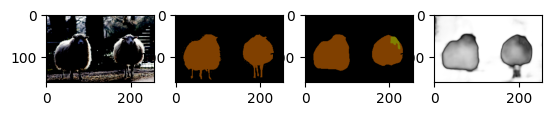

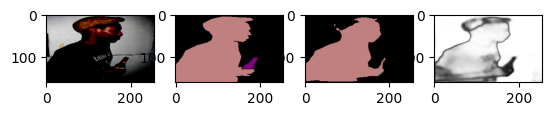

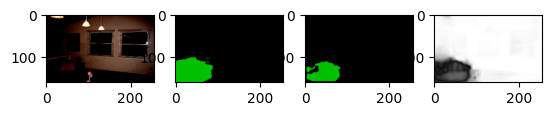

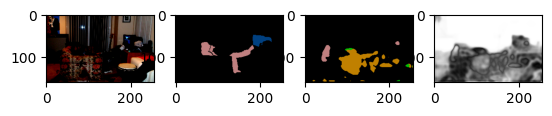

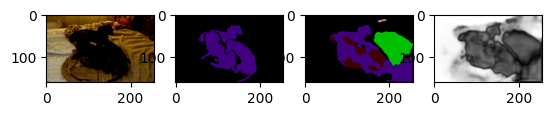

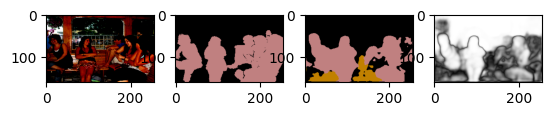

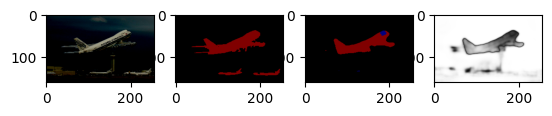

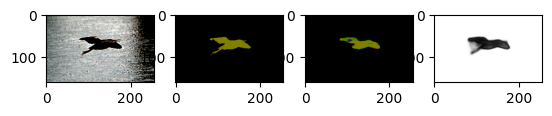

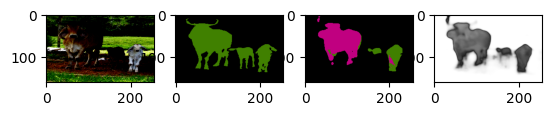

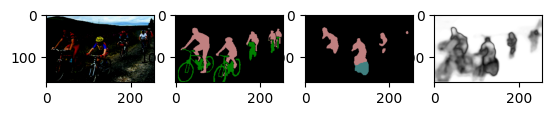

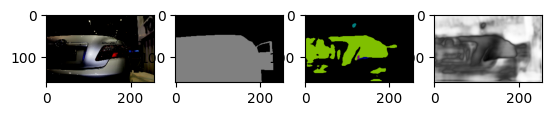

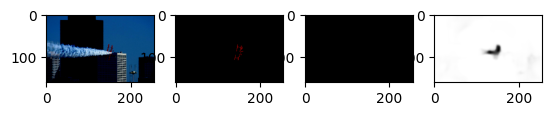

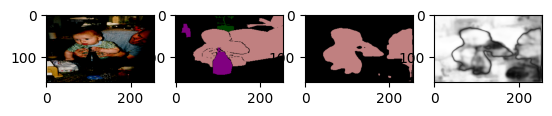

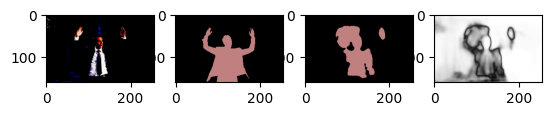

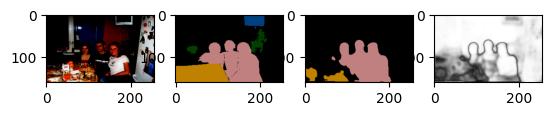

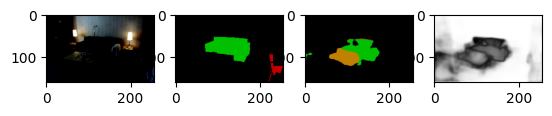

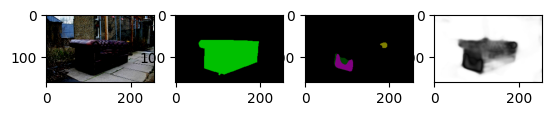

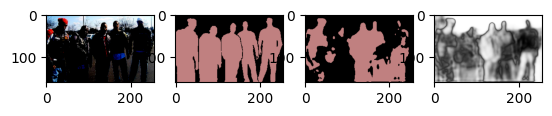

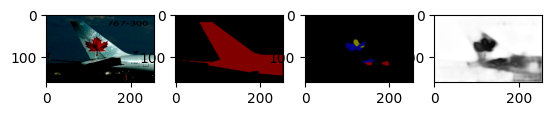

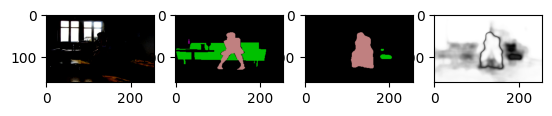

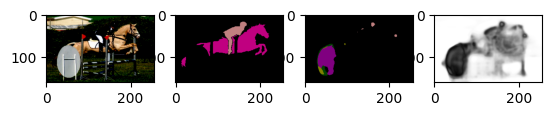

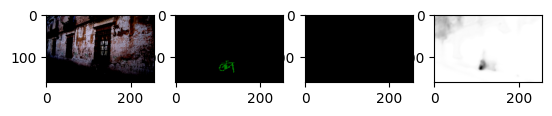

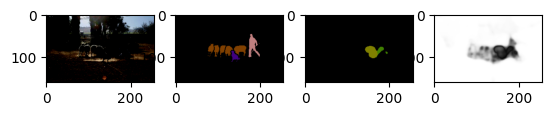

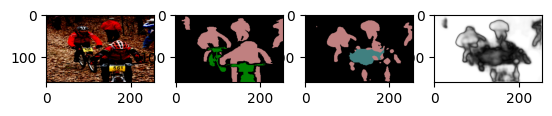

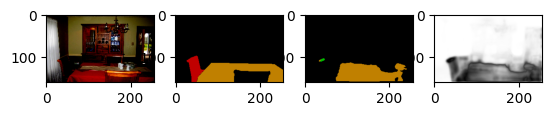

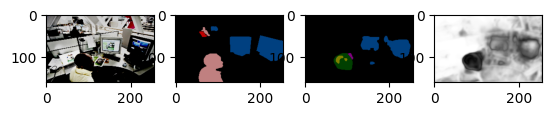

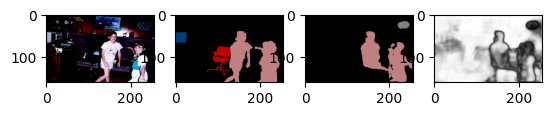

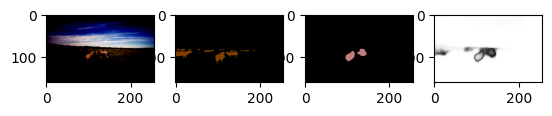

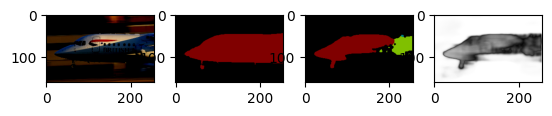

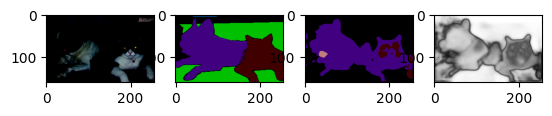

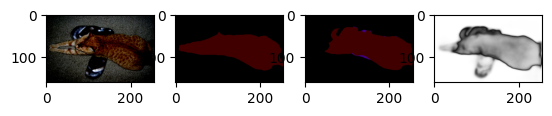

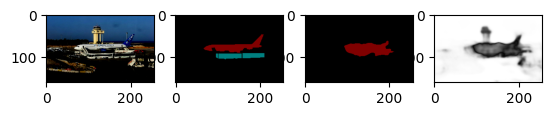

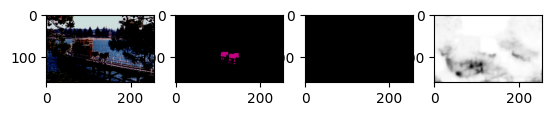

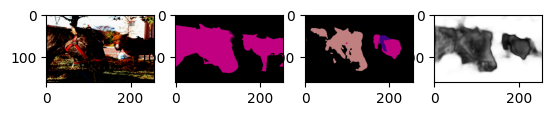

KeyboardInterrupt: 

In [4]:
image_count = 0
with torch.no_grad():
    for images, masks in dataloader:
        # print(images.shape, masks.shape)
        # print(images.dtype, masks.dtype)
        # print(images.min(), images.max(), masks.min(), masks.max())
        images = images.to(hyperparameters.device)
        pred_masks = model(images)
        images, pred_masks = images.to("cpu"), pred_masks.to("cpu")
        for i in range(images.size(0)):
            image, mask, pred_mask = images[i, ...], masks[i, ...], pred_masks[i, ...]
            image = torch.permute(image, dims=(1, 2, 0))
            mask_image = PascalVOCDataset.convert_class_to_color_mask(mask, segmentation_axis=0)
            pred_mask_image = PascalVOCDataset.convert_class_to_color_mask(pred_mask, segmentation_axis=0)
            uncertainty_image = torch.max(torch.softmax(pred_mask, dim=0), dim=0).values
            f, axarr = plt.subplots(1, 4)
            axarr[0].imshow(image, vmin=0, vmax=1)
            axarr[1].imshow(mask_image)
            axarr[2].imshow(pred_mask_image)
            axarr[3].imshow(uncertainty_image, cmap="gray")
            plt.show()